In [2]:
import numpy as np
import vorostereology as vs
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d as m3
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from scipy.spatial import Voronoi, voronoi_plot_2d
import voroplusplus as vpp
import pyvoro
from scipy import ndimage
import pandas as pd
import csv
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern

Text(0.5, 0, 'z')

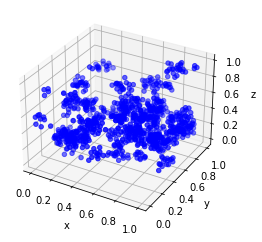

In [30]:
# ######################################## Define/ initialize points##############################################
xMin = 0;
xMax = 1;
yMin = 0;
yMax = 1;
zMin = 0;
zMax = 1;

# Parameters for the parent and daughter point processes
lambdaParent = 50;  # density of parent Poisson point process
lambdaDaughter = 20;  # mean number of points in each cluster
radiusCluster = 0.1;  # radius of cluster disk (for daughter points)

# Extended simulation windows parameters
rExt = radiusCluster;  # extension parameter -- use cluster radius
xMinExt = xMin - rExt;
xMaxExt = xMax + rExt;
yMinExt = yMin - rExt;
yMaxExt = yMax + rExt;
zMinExt = zMin - rExt;
zMaxExt = zMax + rExt;
# rectangle dimensions
xDeltaExt = xMaxExt - xMinExt;
yDeltaExt = yMaxExt - yMinExt;
zDeltaExt = zMaxExt - zMinExt;
volumeTotalExt = xDeltaExt * yDeltaExt*zDeltaExt;  # volume of extended rectangle

# Simulate Poisson point process for the parents
numbPointsParent = np.random.poisson(volumeTotalExt * lambdaParent);  # Poisson number of points
# x and y coordinates of Poisson points for the parent
xxParent = xMinExt + xDeltaExt * np.random.uniform(0, 1, numbPointsParent);
yyParent = yMinExt + yDeltaExt * np.random.uniform(0, 1, numbPointsParent);
zzParent = zMinExt + zDeltaExt * np.random.uniform(0, 1, numbPointsParent);
# Simulate Poisson point process for the daughters (ie final poiint process)
numbPointsDaughter = np.random.poisson(lambdaDaughter, numbPointsParent);
numbPoints = sum(numbPointsDaughter);  # total number of points

# Generate the (relative) locations in polar coordinates by
# simulating independent variables.
theta = 2 * np.pi * np.random.uniform(0, 1, numbPoints);  # angular coordinates
rho = radiusCluster * np.sqrt(np.random.uniform(0, 1, numbPoints));  # radial coordinates
V=2 * np.random.uniform(0, 1, numbPoints)-1;

# Convert from polar to Cartesian coordinates
xx0 = rho * np.cos(theta)* np.sqrt(1-V**2);
yy0 = rho * np.sin(theta)* np.sqrt(1-V**2);
zz0 = rho * V
# replicate parent points (ie centres of disks/clusters)
xx = np.repeat(xxParent, numbPointsDaughter);
yy = np.repeat(yyParent, numbPointsDaughter);
zz = np.repeat(zzParent, numbPointsDaughter);
# translate points (ie parents points are the centres of cluster disks)
xx = xx + xx0;
yy = yy + yy0;
zz = zz + zz0;
# thin points if outside the simulation window
booleInside = ((xx >= xMin) & (xx <= xMax) & (yy >= yMin) & (yy <= yMax)& (zz >= zMin) & (zz <= zMax));
# retain points inside simulation window
xx = xx[booleInside];  
yy = yy[booleInside];
zz = zz[booleInside]
# Plotting
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xx, yy,zz,color='b');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [31]:
len(xx)

979

In [71]:
s=np.array([xx.T,yy.T,zz.T])


In [72]:
#######Generate 3D Voronoi###########
pycells=pyvoro.compute_voronoi(
s.T, # point positions
[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], # limits
1.0, # block size
# particle radii -- optional, and keyword-compatible arg.
)

In [73]:
######Taking 9 cross-sections#####
coeffs = np.array([0.5, 0.0, 0.0])
r1=np.arange(0.3, 0.7, 0.05).tolist()
cross_section_tot=[vs.compute_cross_section(pycells, coeffs, np.array([0.25, 0.5, 1.0]))]
for x in range(0,8):
 cross_section_tot+= [vs.compute_cross_section(pycells, coeffs, np.array([r1[x], 0.5, 1.0]))]
   

NameError: name 'domain' is not defined

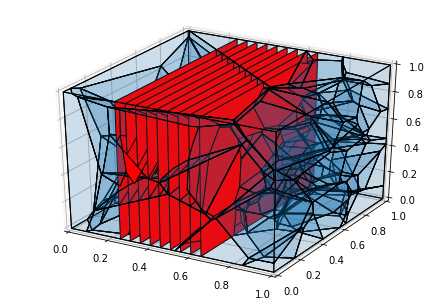

In [74]:
fig = plt.figure()
ax = Axes3D(fig)

for cell_idx, cell in enumerate(pycells):
    for facet_idx, facet in enumerate(cell['faces']):
        idx = np.array(facet['vertices'])
        polygon = m3.art3d.Poly3DCollection([np.array(cell['vertices'])[idx]])
        polygon.set_edgecolor('k')
        polygon.set_alpha(0.1)
        ax.add_collection3d(polygon)


for x in range(0, 9, 1):
    for cell in cross_section_tot[x]['3d']:
        polygon = m3.art3d.Poly3DCollection([cell])
        polygon.set_color("red")
        polygon.set_edgecolor('k')
        ax.add_collection3d(polygon)
    
ax.set_xlim3d(domain[0])
ax.set_ylim3d(domain[1])
ax.set_zlim3d(domain[2])
ax.set_box_aspect((1, 1, 1))
ax.set_axis_off()
plt.show(block=False)



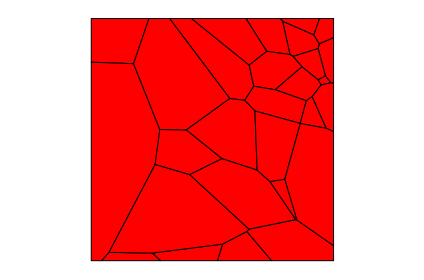

In [75]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

coll = PolyCollection(cross_section_tot[0]['2d'], facecolors="red", edgecolors='k')
ax2.add_collection(coll)
ax2.axis("equal")
ax2.set_axis_off()
fig2.tight_layout()
plt.show()





In [42]:
#####Taking the centroid of the visible grains in the cross-sections and create data-set#####
x = [p[0] for p in cross_section_tot[0]['2d'][0]]
y = [p[1] for p in cross_section_tot[0]['2d'][0]]
centroid0=[(sum(x) / len(cross_section_tot[0]['2d'][0]), sum(y) / len(cross_section_tot[0]['2d'][0]))]
for i in range(1,len(cross_section_tot[0]['2d'])):
     x = [p[0] for p in cross_section_tot[0]['2d'][i]]
     y = [p[1] for p in cross_section_tot[0]['2d'][i]]
     centroid0.append((sum(x) / len(cross_section_tot[0]['2d'][i]), sum(y) / len(cross_section_tot[0]['2d'][i])))
id_sec=pd.DataFrame([0.1]*len(cross_section_tot[0]['2d']),columns=['id_sec'])
id_grains=pd.DataFrame(cross_section_tot[0]['original_indices'],columns=['id_grain'])
df0=pd.DataFrame(centroid0,columns=['x','y'])
df0=pd.concat([df0.reset_index(drop=True), id_sec, id_grains], axis=1)
for j in range(1,8):
    x = [p[0] for p in cross_section_tot[j]['2d'][0]]
    y = [p[1] for p in cross_section_tot[j]['2d'][0]]
    centroidj=[(sum(x) / len(cross_section_tot[j]['2d'][0]), sum(y) / len(cross_section_tot[j]['2d'][0]))]
    for i in range(1,len(cross_section_tot[j]['2d'])):
        x = [p[0] for p in cross_section_tot[j]['2d'][i]]
        y = [p[1] for p in cross_section_tot[j]['2d'][i]]   
        centroidj.append((sum(x) / len(cross_section_tot[j]['2d'][i]), sum(y) / len(cross_section_tot[j]['2d'][i])))
    id_sec=pd.DataFrame([(j+1)*0.1]*len(cross_section_tot[j]['2d']),columns=['id_sec'])
    id_grains=pd.DataFrame(cross_section_tot[j]['original_indices'],columns=['id_grain'])
    dfj=pd.DataFrame(centroidj,columns=['x','y'])
    dfj=pd.concat([dfj.reset_index(drop=True), id_sec, id_grains], axis=1)
    dfj_tot=pd.concat([df0,dfj])
    df0=dfj_tot   



In [ ]:
#####Taking the center of mass of the visible grains in the cross-sections and create data-set#####
center_mass0=[ndimage.measurements.center_of_mass(cross_section_tot[0]['2d'][0])]
for i in range(1,len(cross_section_tot[0]['2d'])):
 center_mass0.append(ndimage.measurements.center_of_mass(cross_section_tot[0]['2d'][i]))

id_sec=pd.DataFrame([0.1]*len(cross_section_tot[0]['2d']),columns=['id_sec'])
id_grains=pd.DataFrame(cross_section_tot[0]['original_indices'],columns=['id_grain'])
df0=pd.DataFrame(center_mass0,columns=['x','y'])
df0=pd.concat([df0.reset_index(drop=True), id_sec, id_grains], axis=1)
for x in range(1,8):
    center_massx=[ndimage.measurements.center_of_mass(cross_section_tot[x]['2d'][0])]
    for i in range(1,len(cross_section_tot[x]['2d'])):
     center_massx.append(ndimage.measurements.center_of_mass(cross_section_tot[x]['2d'][i]))
    id_sec=pd.DataFrame([(x+1)*0.1]*len(cross_section_tot[x]['2d']),columns=['id_sec'])
    id_grains=pd.DataFrame(cross_section_tot[x]['original_indices'],columns=['id_grain'])
    dfx=pd.DataFrame(center_massx,columns=['x','y'])
    dfx=pd.concat([dfx.reset_index(drop=True), id_sec, id_grains], axis=1)
    dfx_tot=pd.concat([df0,dfx])
    df0=dfx_tot   

In [44]:
####Finalize dataset and export data####
id_vor=pd.DataFrame([1]*dfj_tot.shape[0],columns=['id_vor'])
dfj_tot=pd.concat([dfj_tot.reset_index(drop=True), id_vor], axis=1)

In [45]:
dfj_tot.to_csv('dftotcl1.csv')

In [36]:
#########Generazione multipla######
dfj_tot_tot=pd.DataFrame(columns=['x','y','id_sec','id_grain','g_area','id_vor'])
xMin = 0;
xMax = 1;
yMin = 0;
yMax = 1;
zMin = 0;
zMax = 1;

# Parameters for the parent and daughter point processes
lambdaParent = 50;  # density of parent Poisson point process
lambdaDaughter = 20;  # mean number of points in each cluster
radiusCluster = 0.1;  # radius of cluster disk (for daughter points)




# Extended simulation windows parameters
rExt = radiusCluster;  # extension parameter -- use cluster radius
xMinExt = xMin - rExt;
xMaxExt = xMax + rExt;
yMinExt = yMin - rExt;
yMaxExt = yMax + rExt;
zMinExt = zMin - rExt;
zMaxExt = zMax + rExt;
# rectangle dimensions
xDeltaExt = xMaxExt - xMinExt;
yDeltaExt = yMaxExt - yMinExt;
zDeltaExt = zMaxExt - zMinExt;
volumeTotalExt = xDeltaExt * yDeltaExt*zDeltaExt;  # volume of extended rectangle

for k in range(1,401):
    numbPointsParent = np.random.poisson(volumeTotalExt * lambdaParent);  # Poisson number of points
    xxParent = xMinExt + xDeltaExt * np.random.uniform(0, 1, numbPointsParent);
    yyParent = yMinExt + yDeltaExt * np.random.uniform(0, 1, numbPointsParent);
    zzParent = zMinExt + zDeltaExt * np.random.uniform(0, 1, numbPointsParent);
    numbPointsDaughter = np.random.poisson(lambdaDaughter, numbPointsParent);
    numbPoints = sum(numbPointsDaughter);  # total number of points
    theta = 2 * np.pi * np.random.uniform(0, 1, numbPoints);  # angular coordinates
    rho = radiusCluster * np.sqrt(np.random.uniform(0, 1, numbPoints));  # radial coordinates
    V=2 * np.random.uniform(0, 1, numbPoints)-1;
    xx0 = rho * np.cos(theta)* np.sqrt(1-V**2);
    yy0 = rho * np.sin(theta)* np.sqrt(1-V**2);
    zz0 = rho * V
    xx = np.repeat(xxParent, numbPointsDaughter);
    yy = np.repeat(yyParent, numbPointsDaughter);
    zz = np.repeat(zzParent, numbPointsDaughter);
    xx = xx + xx0;
    yy = yy + yy0;
    zz = zz + zz0;
    booleInside = ((xx >= xMin) & (xx <= xMax) & (yy >= yMin) & (yy <= yMax)& (zz >= zMin) & (zz <= zMax));
    xx = xx[booleInside];  
    yy = yy[booleInside];
    zz = zz[booleInside]
    s=np.array([xx.T,yy.T,zz.T])
    pycells=pyvoro.compute_voronoi(
    s.T, [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], 1.0,)
    coeffs = np.array([0.5, 0.0, 0.0])
    r1=np.arange(0.3, 0.7, 0.05).tolist()
    cross_section_tot=[vs.compute_cross_section(pycells, coeffs, np.array([0.25, 0.5, 1.0]))]
    for x in range(0,8):
     cross_section_tot+= [vs.compute_cross_section(pycells, coeffs, np.array([r1[x], 0.5, 1.0]))]
    x = [p[0] for p in cross_section_tot[0]['2d'][0]]
    y = [p[1] for p in cross_section_tot[0]['2d'][0]]
    centroid0=[(sum(x) / len(cross_section_tot[0]['2d'][0]), sum(y) / len(cross_section_tot[0]['2d'][0]))]
    for i in range(1,len(cross_section_tot[0]['2d'])):
         x = [p[0] for p in cross_section_tot[0]['2d'][i]]
         y = [p[1] for p in cross_section_tot[0]['2d'][i]]
         centroid0.append((sum(x) / len(cross_section_tot[0]['2d'][i]), sum(y) / len(cross_section_tot[0]['2d'][i])))
    id_sec=pd.DataFrame([0.1]*len(cross_section_tot[0]['2d']),columns=['id_sec'])
    id_grains=pd.DataFrame(cross_section_tot[0]['original_indices'],columns=['id_grain'])
    grain_area=pd.DataFrame(cross_section_tot[0]['areas'],columns=['g_area'])
    df0=pd.DataFrame(centroid0,columns=['x','y'])
    df0=pd.concat([df0.reset_index(drop=True), id_sec, id_grains,grain_area], axis=1)
    for j in range(1,8):
        x = [p[0] for p in cross_section_tot[j]['2d'][0]]
        y = [p[1] for p in cross_section_tot[j]['2d'][0]]
        centroidj=[(sum(x) / len(cross_section_tot[j]['2d'][0]), sum(y) / len(cross_section_tot[j]['2d'][0]))]
        for i in range(1,len(cross_section_tot[j]['2d'])):
            x = [p[0] for p in cross_section_tot[j]['2d'][i]]
            y = [p[1] for p in cross_section_tot[j]['2d'][i]]   
            centroidj.append((sum(x) / len(cross_section_tot[j]['2d'][i]), sum(y) / len(cross_section_tot[j]['2d'][i])))
        id_sec=pd.DataFrame([(j+1)*0.1]*len(cross_section_tot[j]['2d']),columns=['id_sec'])
        id_grains=pd.DataFrame(cross_section_tot[j]['original_indices'],columns=['id_grain'])
        grain_area=pd.DataFrame(cross_section_tot[j]['areas'],columns=['g_area'])
        dfj=pd.DataFrame(centroidj,columns=['x','y'])
        dfj=pd.concat([dfj.reset_index(drop=True), id_sec, id_grains,grain_area], axis=1)
        dfj_tot=pd.concat([df0,dfj])
        df0=dfj_tot   
    id_vor=pd.DataFrame([k]*dfj_tot.shape[0],columns=['id_vor'])
    dfj_tot=pd.concat([dfj_tot.reset_index(drop=True), id_vor], axis=1)   
    dfj_tot=pd.concat([dfj_tot ,dfj_tot_tot])
    dfj_tot_tot=dfj_tot 
    


In [ ]:
k

In [37]:
dfj_tot_tot.to_csv('dfcl2power1000bis.csv')


In [51]:
np.arange(0.3, 0.7, 0.05).tolist()

[0.3,
 0.35,
 0.39999999999999997,
 0.44999999999999996,
 0.49999999999999994,
 0.5499999999999999,
 0.5999999999999999,
 0.6499999999999999]

In [34]:
 dfj_tot_tot

,x,y,id_sec,id_grain,g_area,id_vor
0,0.933190,-0.160911,0.1,26,0.024265,611
1,0.743148,-0.149282,0.1,31,0.025264,611
2,0.826983,-0.041297,0.1,38,0.019381,611
3,0.667898,-0.025070,0.1,39,0.005705,611
4,0.971936,-0.497809,0.1,45,0.000016,611
...,...,...,...,...,...,...
1034,0.948744,0.282241,0.8,768,0.021331,1
1035,0.998798,0.357928,0.8,769,0.000002,1
1036,0.811632,0.239448,0.8,770,0.036206,1
1037,0.865190,0.113681,0.8,780,0.005475,1
